In [1]:
import PollingSystem as PS
import MarkovianRP as MRP
import StaticRP as SRP
import numpy as np

from matplotlib import pyplot as plt
from importlib import reload 

In [2]:
reload(PS)
beta = 1/16
els = np.array([0.3, 0.01, 0.01])/beta
#els = np.array([0.3, 0.1, 0.1])/beta
ps = PS.PollingSystem(els, beta)
S = np.array([[ 0.        , 11.01635149, 14.27059899],
       [11.01635149,  0.        , 17.132717  ],
       [14.27059899, 17.132717  ,  0.        ]])
#S = 4*np.ones((3,3))

pi = np.array([0.99764782, 0.00135218, 0.001])
#pi = np.array([1/3, 1/3, 1/3])
rp = MRP.RandomRP(pi)
#are we super off with cyclic as well?
#rp = SRP.CyclicRP([0,2,1])
#S = np.array([11.01635149, 14.27059899, 17.132717])
# wait = ps.calc_avg_wait(rp, np.array([S[0,2], S[2,1], S[1,0]]))
hrs = 1
mins = hrs*60
seconds = mins*60
xt, wt, queues, _, avg_switching, polling_instants, T = ps.simulate(rp, S, seconds)



[ 0.08585268 63.34270316 85.65073636]
Empirical backward recurrence times:
 [[7.78979260e-02 1.16185340e+01 1.51916516e+01]
 [4.41023497e+01 5.62848137e+01 6.35508965e+01]
 [8.23179582e+01 9.46622225e+01 9.42971766e+01]]
Thr backward recurrence times:
 [[ 0.08585268 11.67192898 15.14763604]
 [51.75662686 63.34270316 66.81841022]
 [70.588953   82.1750293  85.65073636]]
Thr backward recurrence times alt:
 [[5.51244333e-02 1.16412007e+01 1.51169078e+01]
 [6.33119749e+01 7.48980512e+01 7.83737583e+01]
 [8.56200081e+01 9.72060844e+01 1.00681791e+02]]
Empirical Wait Time: 15.8194
Theoretical Wait Time: 15.6718
Diff: 0.1476 (0.0093)

Empirical pi: [9.97799564e-01 1.37254902e-03 8.27886710e-04]
Theoretical pi: [0.99764782 0.00135218 0.001     ]
Lbar MC Emp: 21.8264
lbar mc thr: 20.0044
Emp mc Lbar_0: 0.3886 
Thr mc Lbar_0: 0.4280
Emp Lbar mc at 0 given 0: 0.2633
Thr Lbar mc at 0 given 0: 0.2885
Emp mc Lbar_1: 7.8638 
Thr mc Lbar_1: 8.2816
Emp Lbar mc at 1 given 1: 9.4762
Thr Lbar mc at 1 given

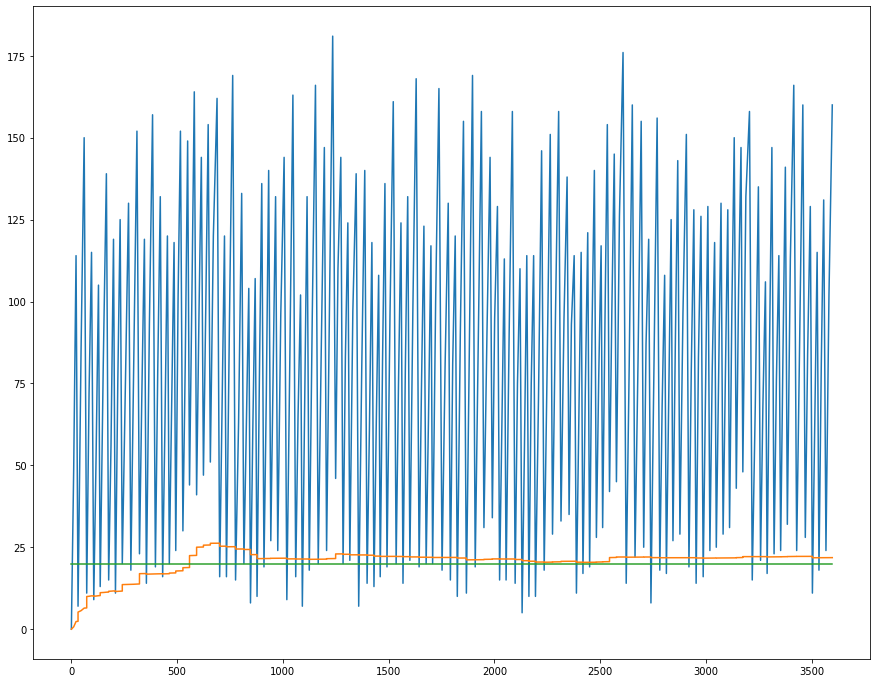

In [3]:
print(ps._cycle_times(S, pi))
print("Empirical backward recurrence times:\n", T)
Tthr = np.array([ [ ps._Tij_avg(S, pi, i, j) for j in range(ps.n)] for i in range(ps.n)])
print("Thr backward recurrence times:\n", Tthr)

wait = ps.calc_avg_wait(S,rp)
print('Empirical Wait Time: %.4f'%(wt[-1][1]))
print("Theoretical Wait Time: %.4f"%(wait))
diff = wt[-1][1] - wait
print("Diff: %.4f (%.4f)\n"%(diff, diff/wt[-1][1]) )

plgis = np.array(polling_instants)
uni, counts = np.unique(plgis[:,1], return_counts = True)

print("Empirical pi:", (counts/sum(counts)))
print("Theoretical pi:", (pi))

xt = np.array(xt)
int_queue_length = 0
average_at_polling = 0
for i in range(len(xt)-1):
    int_queue_length += (xt[i+1,0]-xt[i,0])*sum(xt[i,2:])


Lbarmc = 0
sys_lengths = []
sys_lengths_i = []
lbar_i_given_i = np.zeros(3)
for i in range(len(plgis)):
    inst = plgis[i,0]
    z = int(plgis[i,1])
    idx = np.where(xt[:,0]==inst)
#     print(idx)
    idx = idx[0][0]
    sys_lengths.append(sum(xt[idx,2:]))
    sys_lengths_i.append(xt[idx,2:])
    lbar_i_given_i[z] += xt[idx, 2+z]
    Lbarmc += sys_lengths[-1]
plt.figure(figsize=(15,12))   
plt.plot(plgis[:,0], sys_lengths)
plt.plot(plgis[:,0], np.cumsum(sys_lengths)/np.arange(1,len(sys_lengths)+1,1) )
print("Lbar MC Emp: %.4f"%(Lbarmc/len(plgis)))
Lmc = ps._LSys_mc_avg(S, pi)
print("lbar mc thr: %.4f"%(Lmc))
plt.plot([0,plgis[-1,0]], [Lmc, Lmc])


sys_lengths_i = np.array(sys_lengths_i)
for i in range(3):
    print("Emp mc Lbar_%d: %.4f "%(i,np.average(sys_lengths_i[:,i]) ))
    print("Thr mc Lbar_%d: %.4f"%(i, ps._Li_mc_avg(S, pi,i)))
    print("Emp Lbar mc at %d given %d: %.4f"%(i, i, lbar_i_given_i[i]/counts[i] ))
    print("Thr Lbar mc at %d given %d: %.4f"%(i, i, ps._Li_mc_avg_at_i(S, pi,i)))
    
lbar = int_queue_length/xt[-1][0]
print("Empirical lbar:%f" %(lbar))
#littles_law_wait
print('Expected Lbar from Little\'s, Thr Wait: %.4f'%(wait*sum(els)))#over all time
#print("Theoretical Lbar: %.4f"%(wait2*sum(els)))


print("Empirical Average Switching: %f"%( avg_switching))
sbar = pi.T@ S @pi
print("thr Average Switching: %f"%(sbar))

print("Thr W based on empirical lbar: %f"%(lbar/sum(els)))

print("Empirical average stage duration: %.4f"%( (plgis[-1,0] - plgis[0,0])/(len(plgis) -1) ))
print("Theoretical average stage duration: %.4f"%(sbar/(1-beta*sum(els))))

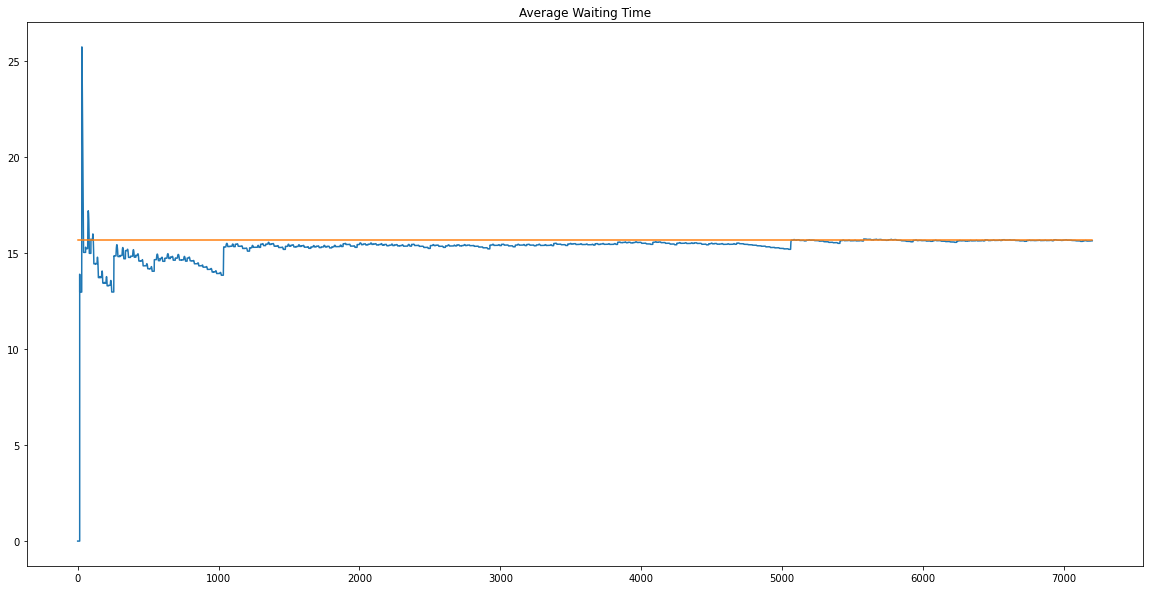

In [61]:
wt = np.array(wt)
fig = plt.figure(figsize=[20,10])
plt.plot(wt[:,0], wt[:,1])
plt.title("Average Waiting Time")
#plt.xlim(6500,8000)
#plt.ylim(12,13)
plt.plot([0, wt[-1, 0]], [wait, wait])
plt.show()

In [62]:
#NOTE: decreasing switching time does NOT guarantee decreasing average waiting time

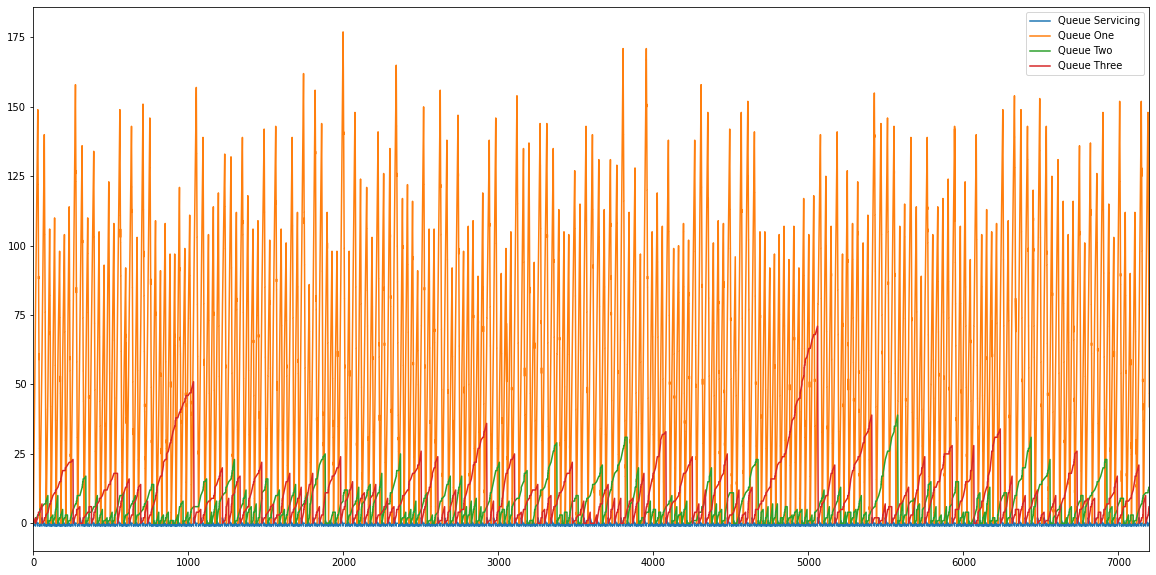

In [63]:
xt = np.array(xt)
fig = plt.figure(figsize=[20,10])
plt.plot(xt[:,0], xt[:,1], label = 'Queue Servicing')
plt.plot(xt[:,0], xt[:,2], label = 'Queue One')
plt.plot(xt[:,0], xt[:,3], label = 'Queue Two')
plt.plot(xt[:,0], xt[:,4], label = 'Queue Three')
plt.legend()
plt.xlim(0,seconds)
# plt.ylim(-2,110)
plt.show()

In [79]:
def pi_to_P(pi):
    n = len(pi)

    #calculate true probability transitions
    P = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i != j:
                P[i,j] = pi[j]
        P[i,:] /= sum(P[i,:])
    v, M = np.linalg.eig(P.T)

    pi_tilde = M[:,0]/sum(M[:,0]) 
    return P, pi_tilde

158.5227923519157


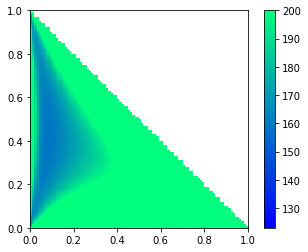

0.14068548785746385 158.52007816111094


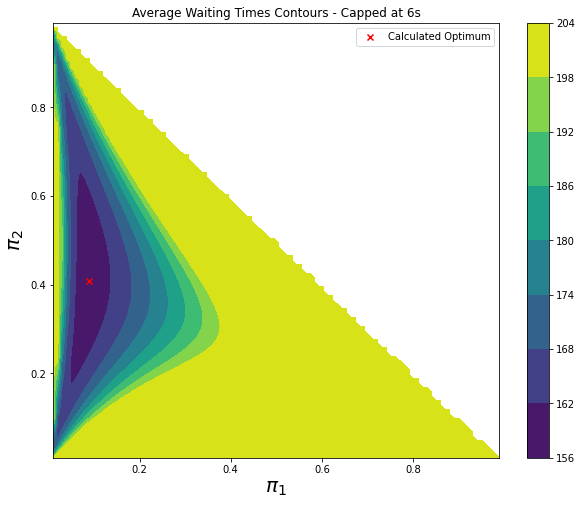

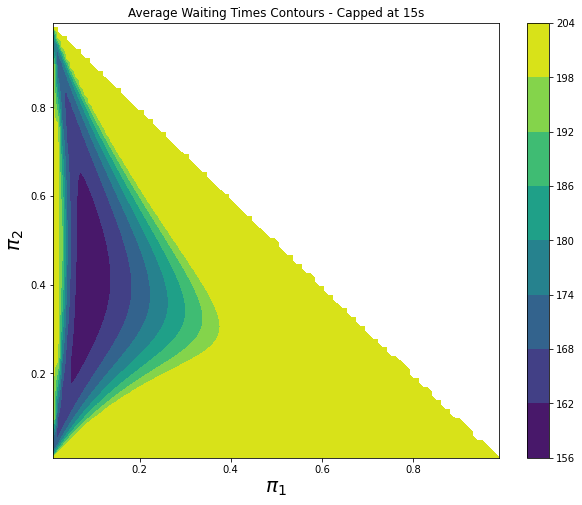

158.69098004150823


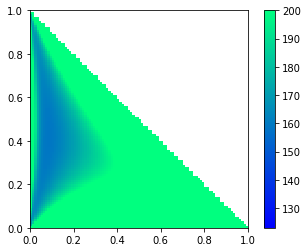

0.14127611463169676 158.69008065210667


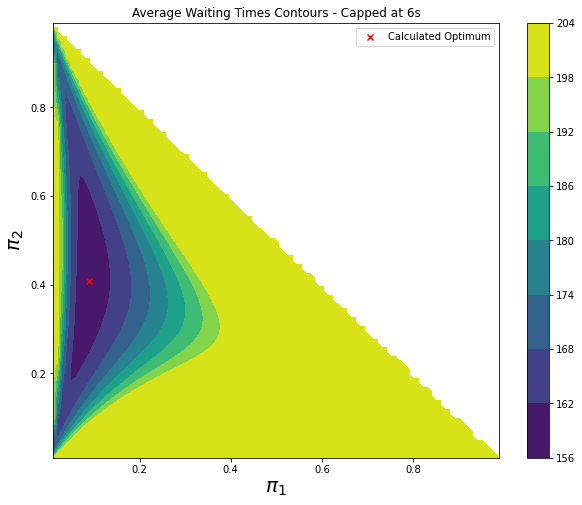

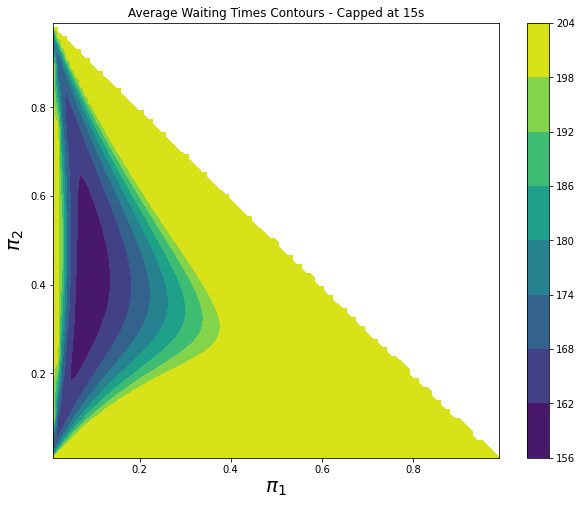

158.85823951527036


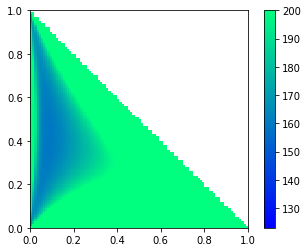

0.1418528486149739 158.858037629018


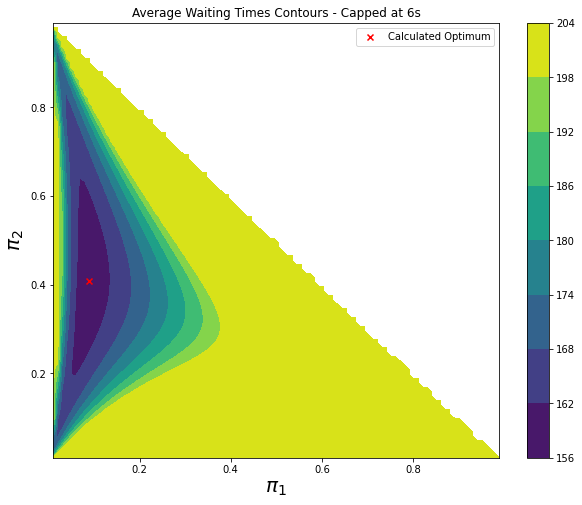

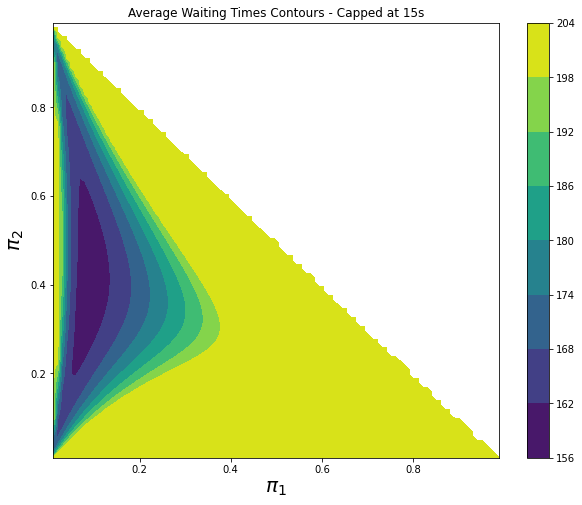

159.02458071898116


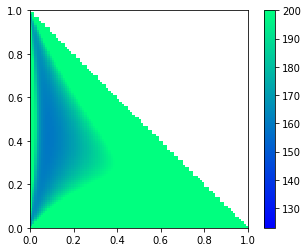

0.14243280718752027 159.023988101067


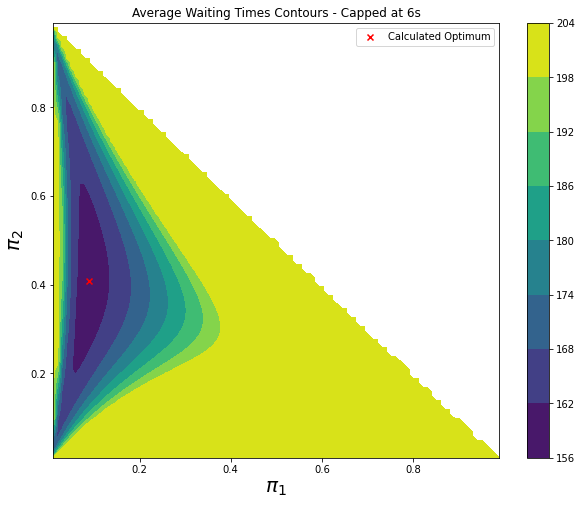

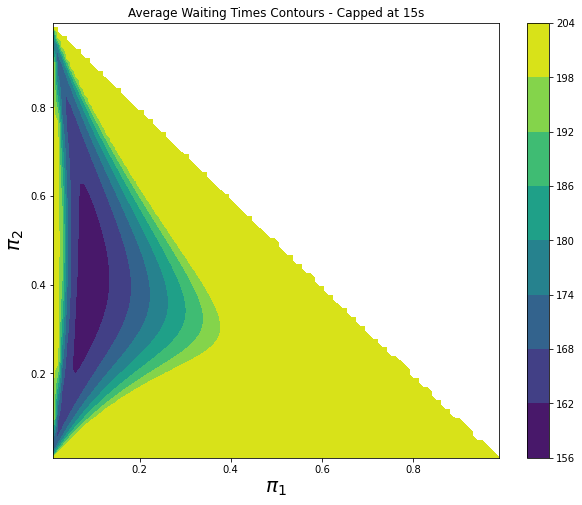

159.19001346492647


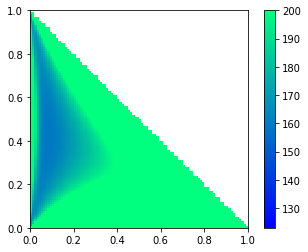

0.14300895397635882 159.18797040849586


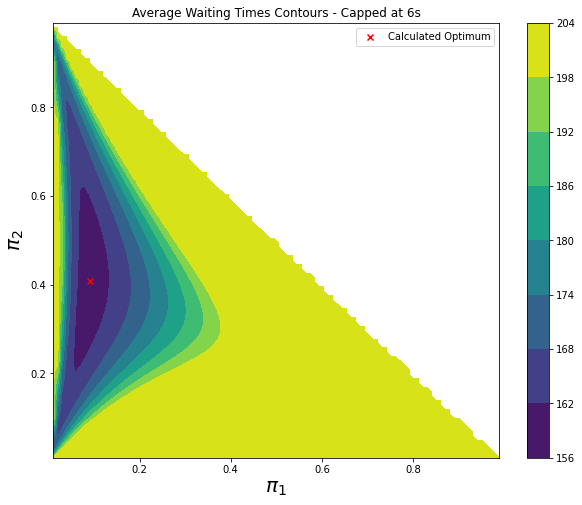

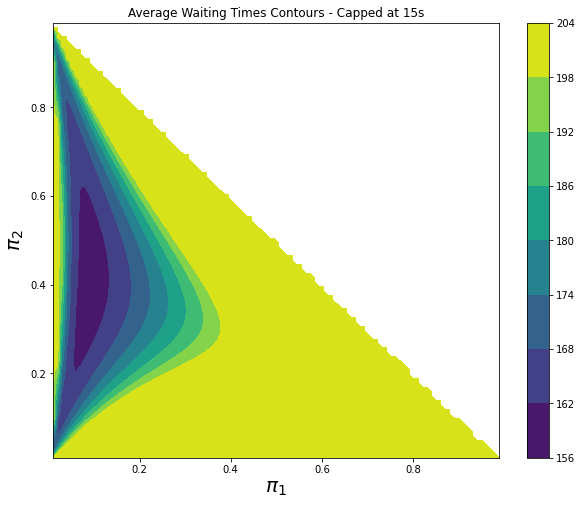

159.354547434159


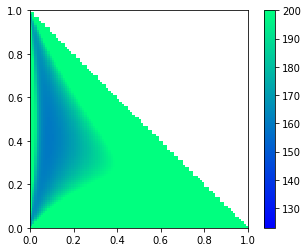

0.1435909010699519 159.35002181932524


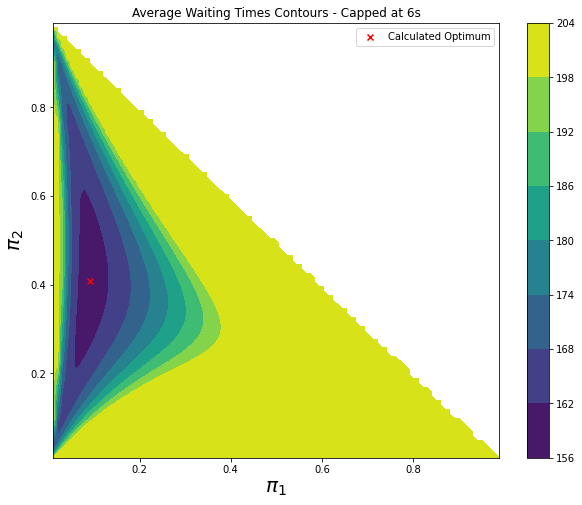

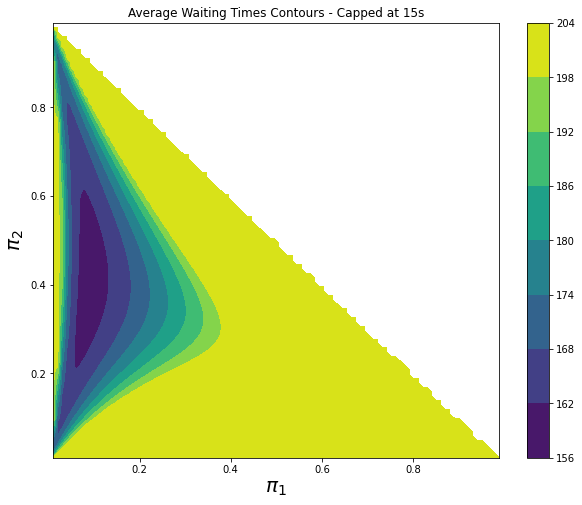

159.5181921787123


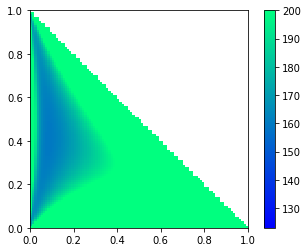

0.14416284182624453 159.51017927841224


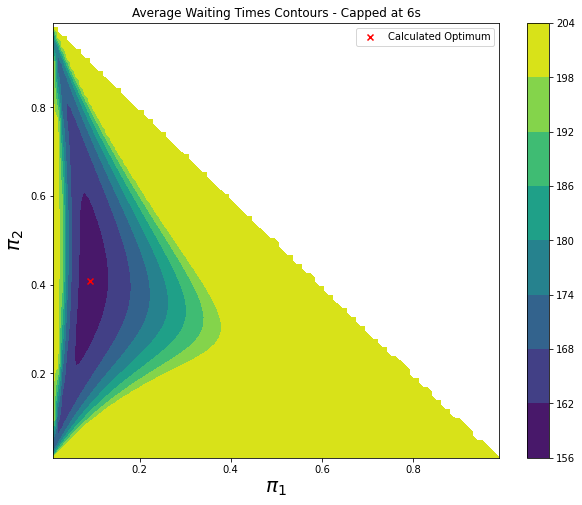

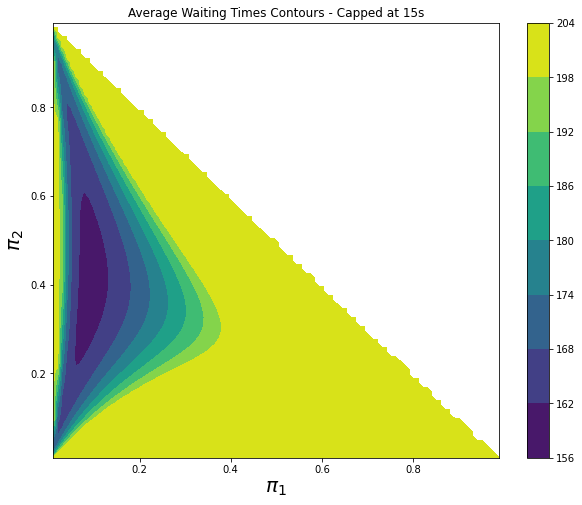

159.68095712377053


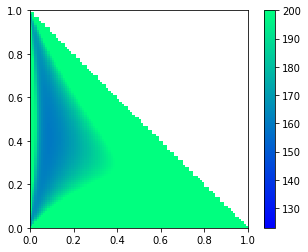

0.1447447600509733 159.66847847188194


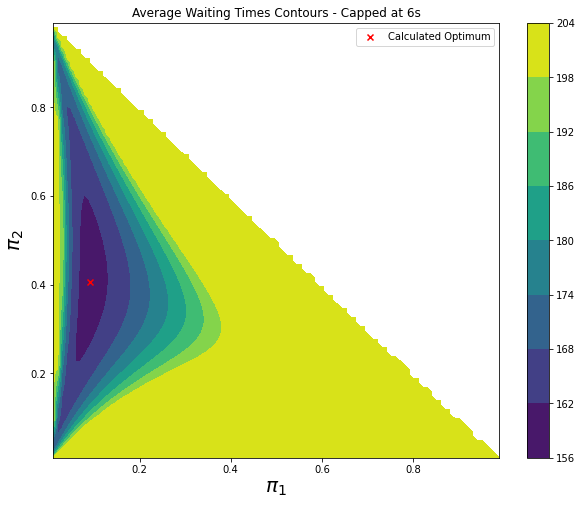

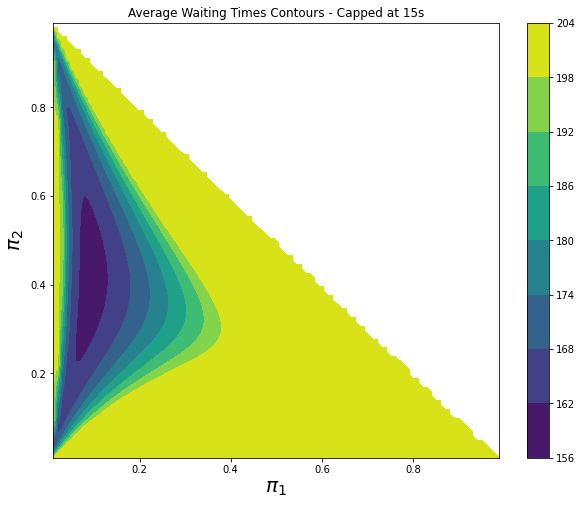

159.84285156979456


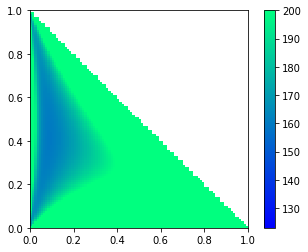

0.1453068273127212 159.82495359986214


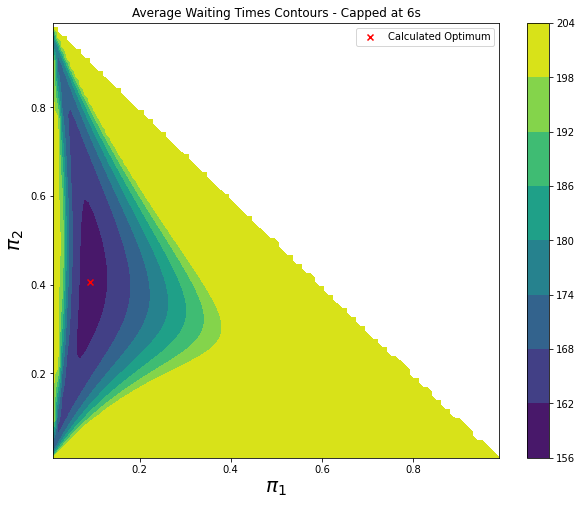

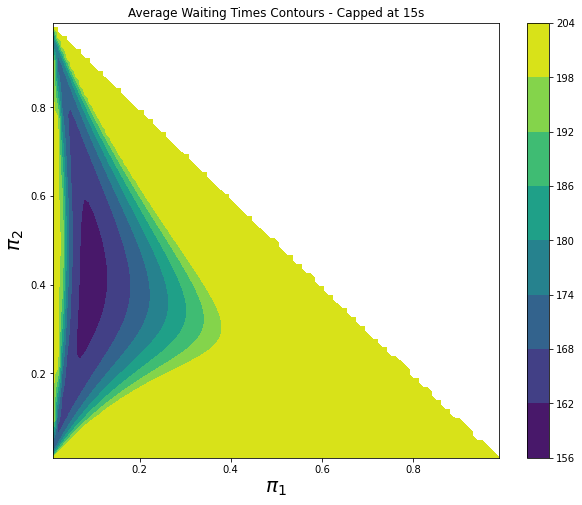

160.00388469460583


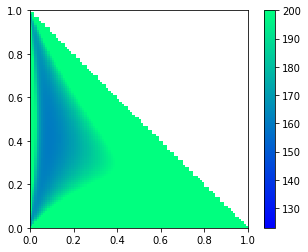

0.1458669850845707 159.97963907182296


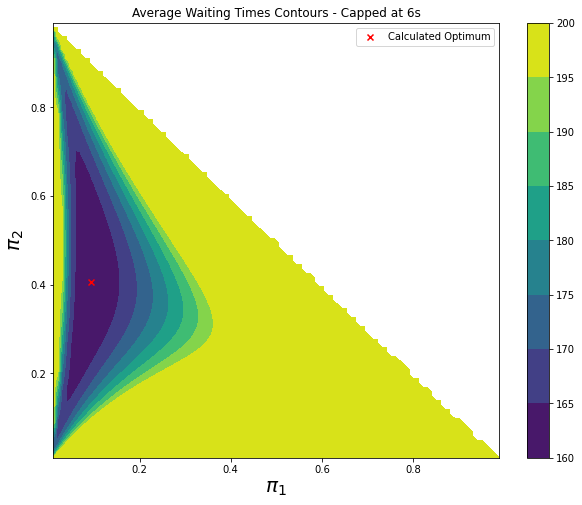

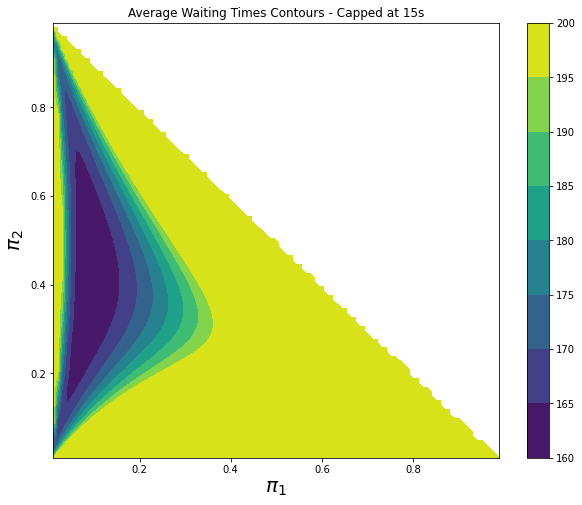

Text(0, 0.5, '$\\pi_2$')

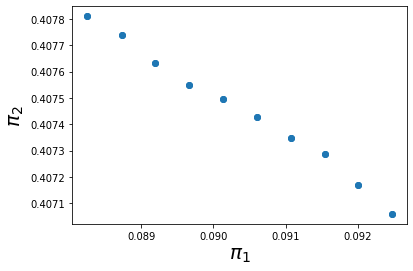

In [95]:
import matplotlib
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

beta = 1/16
base = 0.05/beta
els = base*np.ones(3)

#==============================
# Pull these from the other notebook
#==============================

cmin = 1.4642857142857142
cmax = 1.5714285714285714

S = np.array([[0, 121.90679277, 117.36166224],
             [121.90679277, 0, 13.62093976],
             [117.36166224, 13.62093976, 0]])
xs = []
for c in np.linspace(cmin, cmax, 10):
    els[0] = base*c
    ps = PS.PollingSystem(els, beta)


    gran = 100
    pi1 = np.linspace(1/gran,1-(1/gran), gran)
    pi2 = np.linspace(1/gran,1 - (1/gran), gran)
    Z = -1*np.Inf*np.ones([gran, gran])

    fmin = 10000
    for i in range(gran):
        for j in range(gran):
            pi = np.array([pi1[i], pi2[j], 1 - pi1[i] - pi2[j]])
            if pi[2] > 0:
                Z[i,j] = ps._calc_avg_wait_random(S, pi)
                if Z[i,j] < fmin:
                    fmin=Z[i,j]
    print(fmin)

    fig, ax = plt.subplots()
    ws = ax.imshow(np.transpose(Z), extent=[0,1,0,1], cmap='winter', interpolation='nearest',
                   vmin=123,vmax=200, origin='lower')
    fig.colorbar(ws)
    plt.show()

    fig = plt.figure(figsize=(10,8))
    cont = plt.contourf(pi1, pi2, np.minimum(Z.T, 200))
    #cont = plt.contourf(pi1, pi2, np.minimum(np.log(Z.T), 2.6) )
    fig.colorbar(cont)
    argmin, valmin = ps.calc_optimal_rp(S)
    xs.append(argmin)
    P, pi_tilde = pi_to_P(argmin)
    #xs.append(pi_tilde)
    xs.append(argmin)
    plt.scatter(argmin[0], argmin[1], label='Calculated Optimum', marker='x', c='r')
    print(pi_tilde[0], valmin)
    plt.legend()
    plt.title('Average Waiting Times Contours - Capped at 6s')
    plt.xlabel('$\pi_1$', fontsize=20)
    plt.ylabel('$\pi_2$', fontsize=20)
    plt.show()

    fig = plt.figure(figsize=(10,8))
    cont = plt.contourf(pi1, pi2, np.minimum(Z.T, 200))
    fig.colorbar(cont)
    plt.title('Average Waiting Times Contours - Capped at 15s')
    plt.xlabel('$\pi_1$', fontsize=20)
    plt.ylabel('$\pi_2$', fontsize=20)
    plt.show()
    
xs = np.array(xs)
plt.scatter(xs[:,0],xs[:,1] )
plt.xlabel('$\pi_1$', fontsize=20)
plt.ylabel('$\pi_2$', fontsize=20)


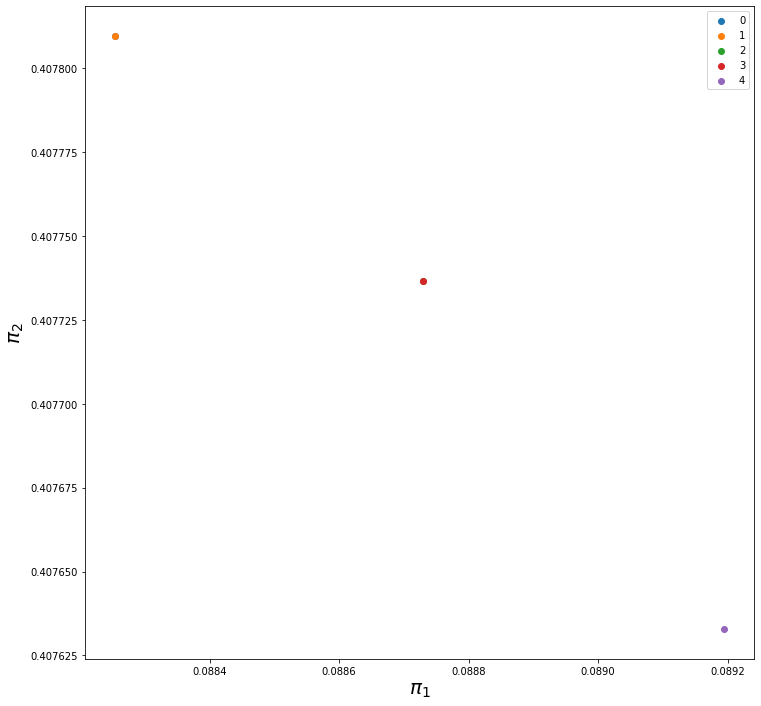

In [98]:
fig = plt.figure(figsize=(12,12))
xs = np.array(xs)
k = 0
for i in range(5):
    x = xs[i]
    plt.scatter(x[0],x[1], label="%d"%(k) )
    k+=1
plt.xlabel('$\pi_1$', fontsize=20)
plt.ylabel('$\pi_2$', fontsize=20)
plt.legend()

In [10]:
#Contours are clearly non-convex. We're not dealing with a convex function.
#There doesn't seem to be a good way to verify unimodality, either